# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import string
import pickle

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.collocations import *

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

import re
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gustavo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gustavo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gustavo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
os.getcwd()

'C:\\Users\\Gustavo\\flatiron\\class-material\\section04\\Phase04Project\\Notebooks'

In [3]:
if os.getcwd() == '/content':
    from google.colab import drive
    drive.mount('/content/drive')

In [4]:
os.getcwd()

'C:\\Users\\Gustavo\\flatiron\\class-material\\section04\\Phase04Project\\Notebooks'

In [5]:
#Importing in data
if os.getcwd() == '/content':
  data = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Phase04Project/Data/judge_tweet_product_company.xlsx")
else:
  data = pd.read_excel("../Data/judge_tweet_product_company.xlsx")

#Allowing all text in tweet to be displayed
pd.set_option('display.max_colwidth', -1)

#Changing the names of the columns to simpler ones
data.columns = ['tweet','product','emotion']
data.head(10)

,tweet,product,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive emotion


# Dealing with missing data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet      9092 non-null object
product    3291 non-null object
emotion    9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


In [7]:
data.isna().sum()

tweet      1   
product    5802
emotion    0   
dtype: int64

One tweet is missing data, we can drop this tweet. for the majority of tweets in our dataset the target of the emotion is not defined.

In [8]:
data.dropna(axis=0, subset=['tweet'], inplace=True)
data.isna().sum()

tweet      0   
product    5801
emotion    0   
dtype: int64

In [9]:
#Looking at first 50 with undefined product
data[data['product'].isna()][:50]

,tweet,product,emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store - http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register for #GDGTLive and see Cobra iRadar for Android. {link}",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
34,Anyone at #SXSW who bought the new iPad want to sell their older iPad to me?,NaN,No emotion toward brand or product
35,"At #sxsw. Oooh. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link}",NaN,No emotion toward brand or product
37,SPIN Play - a new concept in music discovery for your iPad from @mention &amp; spin.com {link} #iTunes #sxsw @mention,NaN,No emotion toward brand or product
39,VatorNews - Google And Apple Force Print Media to Evolve? {link} #sxsw,NaN,No emotion toward brand or product
41,"HootSuite - HootSuite Mobile for #SXSW ~ Updates for iPhone, BlackBerry &amp; Android: Whether you‰Ûªre getting friend... {link}",NaN,No emotion toward brand or product
42,Hey #SXSW - How long do you think it takes us to make an iPhone case? answer @mention using #zazzlesxsw and we‰Ûªll make you one!,NaN,No emotion toward brand or product


A lot of them do mention a product, or are generally talking about either the sxsw event or something related to the event with no discernable feeling.

In [10]:
print("Value Counts of emotion of entire dataset \n")
display(data['emotion'].value_counts())
print("\n\n Value Counts of emotion of dataset with no product attached")
display(data[data['product'].isna()]['emotion'].value_counts())

Value Counts of emotion of entire dataset 



No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                      570 
I can't tell                          156 
Name: emotion, dtype: int64



 Value Counts of emotion of dataset with no product attached


No emotion toward brand or product    5297
Positive emotion                      306 
I can't tell                          147 
Negative emotion                      51  
Name: emotion, dtype: int64

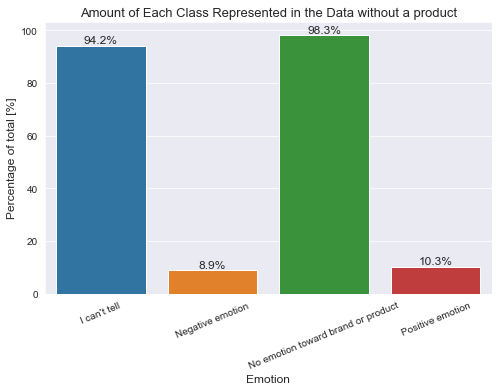

In [11]:
full_counts = data['emotion'].value_counts()
subbed_counts = data[data['product'].isna()]['emotion'].value_counts()

#Displaying percentage of values for each class that come from subbed set
percentage_counts = subbed_counts/full_counts

plt.figure(figsize=(8,5))
sns.set_style('darkgrid')
bp = sns.barplot(x=list(percentage_counts.keys()), y= percentage_counts*100)

bp.set_ylabel('Percentage of total [%]', fontsize=12)
bp.set_xlabel('Emotion', fontsize=12)
bp.set_xticklabels(labels=list(percentage_counts.keys()), rotation=22.5)
bp.set_title("Amount of Each Class Represented in the Data without a product", fontsize=13)

for patch in bp.patches:
    x = patch.get_bbox().get_points()[:,0]
    y = patch.get_bbox().get_points()[1,1]
    bp.annotate("{:.1f}%".format(y), (x.mean(), y),\
            ha= 'center', va= 'bottom', fontsize= 'large') 

plt.show()

What this says about the data is that when no product is discerned, it is more likely that there is no emotion towards the product or that one cannot tell what the emotion is. Since I will be treating this as a ternary classification problem, since "I can't tell" does not provide me with any specific emotion or direction, and since the majority of that class is within this subset, I am choosing to drop all rows where the emotion was classified as "I can't tell".

In [12]:
#Replacing 'I cant tell' with nans
data['emotion'].replace({"I can't tell": np.nan}, inplace= True)
#Removing nans in emotion
data.dropna(subset=['emotion'], axis=0, inplace= True)

In [13]:
data.isna().sum()

tweet      0   
product    5654
emotion    0   
dtype: int64

In [14]:
display(data['emotion'].value_counts())
print(len(data))

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                      570 
Name: emotion, dtype: int64

8936


I've reduced the size of the data a little bit and have removed some unknown and useless values. The data missing in product has some value and information in the fact that it is missing. The overwhelming majority of the tweets that display no emotion whatsoever are located within it and because of this I will leave it as missing.

# Preprocessing

In [15]:
#Resetting index on dataframe
data.reset_index(inplace= True)
data.drop(columns= 'index', inplace= True)
data.head(10)

,tweet,product,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,NaN,No emotion toward brand or product
6,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive emotion
7,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,iPad or iPhone App,Positive emotion
8,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive emotion
9,Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1. #fail,Android,Positive emotion


In [16]:
#Creating function that will preprocess and tokenize the data
def preprocess(X):
    """Takes in str X and processes it to tokens
    """
    #lowercases everything
    X = X.lower()
    
    #Removes all mentions and removes all punctuation
    subpattern = f'(@[A-z0-9]*)|[{string.punctuation[1:].replace("@","")}]*'
    replacer = re.compile(subpattern)
    X = replacer.sub('',X)
    
    #Tokenizes the text. wrote it this way so that it also pulls words with numbers
    tokenpattern = '([0-9]*[a-z]+[0-9]*[a-z]*)'
    tokenizer = re.compile(tokenpattern)
    X = tokenizer.findall(X)
    
    #Removes stopwords
    stopwords_list = stopwords.words('english') + ['sxsw']
    X = [word for word in X if word not in stopwords_list]
    
    #lemmatizes
    lemmatizer = WordNetLemmatizer()
    X = [lemmatizer.lemmatize(word) for word in X]
    X = ' '.join(X)
    
    return X


In [17]:
#Removing punctuation, mentions, stopwords, and lemmatizing the text
data['tweet'] = data['tweet'].apply(lambda x: preprocess(x))

In [18]:
data.head(10)

,tweet,product,emotion
0,3g iphone hr tweeting riseaustin dead need upgrade plugin station,iPhone,Negative emotion
1,know awesome ipadiphone app youll likely appreciate design also theyre giving free t,iPad or iPhone App,Positive emotion
2,wait ipad also sale,iPad,Positive emotion
3,hope year festival isnt crashy year iphone app,iPad or iPhone App,Negative emotion
4,great stuff fri marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress,Google,Positive emotion
5,new ipad apps speechtherapy communication showcased conference httphtly49n 4m iear edchat asd,NaN,No emotion toward brand or product
6,starting ctia around corner googleio hop skip jump good time android fan,Android,Positive emotion
7,beautifully smart simple idea rt wrote hollergram ipad app httpbitlyieavob,iPad or iPhone App,Positive emotion
8,counting day plus strong canadian dollar mean stock apple gear,Apple,Positive emotion
9,excited meet show sprint galaxy still running android fail,Android,Positive emotion


In [19]:
display(data['product'].value_counts())
print(data['product'].unique())

iPad                               942
Apple                              659
iPad or iPhone App                 470
Google                             429
iPhone                             296
Other Google product or service    292
Android App                        81 
Android                            78 
Other Apple product or service     35 
Name: product, dtype: int64

['iPhone' 'iPad or iPhone App' 'iPad' 'Google' nan 'Android' 'Apple'
 'Android App' 'Other Google product or service'
 'Other Apple product or service']


I will convert this into 3 categories. "Apple", "Google", and "No specific brand". The nan values will be the ones converted. since there is important info in the fact that they are missing, that is what drives this decision of mine.

In [20]:
product_replacement_dict = {'iPad':'Apple',\
                            'iPad or iPhone App':'Apple',\
                           'Other Apple product or service': 'Apple',\
                            'iPhone':'Apple',\
                           'Other Google product or service':'Google',\
                            'Android':'Google',\
                            'Android App':'Google',\
                            np.nan : 'No specific brand'
                           }
data['product'].replace(product_replacement_dict, inplace= True)

In [21]:
data.head(10)

,tweet,product,emotion
0,3g iphone hr tweeting riseaustin dead need upgrade plugin station,Apple,Negative emotion
1,know awesome ipadiphone app youll likely appreciate design also theyre giving free t,Apple,Positive emotion
2,wait ipad also sale,Apple,Positive emotion
3,hope year festival isnt crashy year iphone app,Apple,Negative emotion
4,great stuff fri marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress,Google,Positive emotion
5,new ipad apps speechtherapy communication showcased conference httphtly49n 4m iear edchat asd,No specific brand,No emotion toward brand or product
6,starting ctia around corner googleio hop skip jump good time android fan,Google,Positive emotion
7,beautifully smart simple idea rt wrote hollergram ipad app httpbitlyieavob,Apple,Positive emotion
8,counting day plus strong canadian dollar mean stock apple gear,Apple,Positive emotion
9,excited meet show sprint galaxy still running android fail,Google,Positive emotion


In [24]:
for brand in data['product'].unique():
    print("----Value Counts for {}----".format(brand))
    display(data[data['product'] == brand]['emotion'].value_counts())
    display(data[data['product'] == brand]['emotion'].value_counts(normalize=True))
    print("\n")

----Value Counts for Apple----


Positive emotion                      1949
Negative emotion                      388 
No emotion toward brand or product    65  
Name: emotion, dtype: int64

Positive emotion                      0.811407
Negative emotion                      0.161532
No emotion toward brand or product    0.027061
Name: emotion, dtype: float64



----Value Counts for Google----


Positive emotion                      723
Negative emotion                      131
No emotion toward brand or product    26 
Name: emotion, dtype: int64

Positive emotion                      0.821591
Negative emotion                      0.148864
No emotion toward brand or product    0.029545
Name: emotion, dtype: float64



----Value Counts for No specific brand----


No emotion toward brand or product    5297
Positive emotion                      306 
Negative emotion                      51  
Name: emotion, dtype: int64

No emotion toward brand or product    0.936859
Positive emotion                      0.054121
Negative emotion                      0.009020
Name: emotion, dtype: float64

In [25]:
data[data['product'] == 'No specific brand'].head(10)

,tweet,product,emotion
5,new ipad apps speechtherapy communication showcased conference httphtly49n 4m iear edchat asd,No specific brand,No emotion toward brand or product
15,holler gram ipad itunes app store httptcokfn3f 5q via,No specific brand,No emotion toward brand or product
31,attn frineds register gdgtlive see cobra iradar android link,No specific brand,No emotion toward brand or product
32,anyone want sell old ipad,No specific brand,No emotion toward brand or product
33,anyone bought new ipad want sell older ipad,No specific brand,No emotion toward brand or product
34,oooh rt google launch major new social network called circle possibly today link,No specific brand,No emotion toward brand or product
36,spin play new concept music discovery ipad amp spincom link itunes,No specific brand,No emotion toward brand or product
38,vatornews google apple force print medium evolve link,No specific brand,No emotion toward brand or product
40,hootsuite hootsuite mobile update iphone blackberry amp android whether getting friend link,No specific brand,No emotion toward brand or product
41,hey long think take u make iphone case answer using zazzlesxsw make one,No specific brand,No emotion toward brand or product


Value counts for Apple and Google are similar in terms of percentage of how many reviews are positive when compared to negative ones.

# EDA

## Frequency Distribution in Positive and Negative Reviews

In [26]:
#Splitting into positive and negative reviews
positive = data[data['emotion'] == 'Positive emotion']
negative = data[data['emotion'] == 'Negative emotion']

In [27]:
#Creating tokens from lists
pos_tokens = [word_tokenize(x) for x in positive['tweet']]
neg_tokens = [word_tokenize(x) for x in negative['tweet']]


In [28]:
#Making each token list 1-D for frequency distribution calculation
total_positive_tokens = []
total_negative_tokens = []
for pos_list, neg_list in zip(pos_tokens, neg_tokens):
  total_positive_tokens += pos_list
  total_negative_tokens += neg_list


In [29]:
positive_freqdist = FreqDist(total_positive_tokens)
negative_freqdist = FreqDist(total_negative_tokens)

In [30]:
print("There are a total of {} tokens in positive reviews. The 40 most common are: \n".format(len(set(total_positive_tokens))))
positive_freqdist.most_common(40)

There are a total of 1795 tokens in positive reviews. The 40 most common are: 



[('link', 265),
 ('apple', 194),
 ('ipad', 177),
 ('store', 122),
 ('google', 120),
 ('app', 91),
 ('iphone', 90),
 ('rt', 89),
 ('new', 85),
 ('austin', 63),
 ('popup', 48),
 ('android', 47),
 ('ipad2', 47),
 ('launch', 45),
 ('win', 39),
 ('amp', 38),
 ('get', 38),
 ('circle', 37),
 ('social', 36),
 ('network', 32),
 ('via', 31),
 ('today', 31),
 ('line', 29),
 ('one', 28),
 ('love', 26),
 ('even', 26),
 ('begin', 26),
 ('great', 24),
 ('party', 24),
 ('temporary', 24),
 ('major', 24),
 ('people', 23),
 ('im', 23),
 ('open', 23),
 ('sxswi', 23),
 ('called', 23),
 ('check', 21),
 ('like', 21),
 ('go', 21),
 ('day', 20)]

In [31]:
print("There are a total of {} tokens in negative reviews. The 40 most common are: \n".format(len(set(total_negative_tokens))))
negative_freqdist.most_common(40)

There are a total of 2033 tokens in negative reviews. The 40 most common are: 



[('ipad', 181),
 ('iphone', 155),
 ('google', 141),
 ('rt', 137),
 ('apple', 107),
 ('link', 102),
 ('app', 60),
 ('store', 45),
 ('new', 43),
 ('like', 42),
 ('circle', 36),
 ('need', 35),
 ('social', 30),
 ('apps', 30),
 ('people', 29),
 ('design', 28),
 ('get', 25),
 ('android', 24),
 ('austin', 24),
 ('one', 23),
 ('think', 23),
 ('time', 23),
 ('dont', 21),
 ('launch', 21),
 ('look', 21),
 ('line', 20),
 ('say', 20),
 ('day', 20),
 ('would', 19),
 ('news', 18),
 ('today', 18),
 ('go', 17),
 ('long', 17),
 ('phone', 17),
 ('fail', 17),
 ('year', 16),
 ('user', 16),
 ('battery', 16),
 ('product', 16),
 ('headache', 15)]

### N-grams of Positive and Negative reviews

In [32]:
#Function to generate ngrams of any size
def generate_ngram(X, size, additional_stopwords=None):
  #Adds the possibility of adding more stopwords if the desire is there
  if additional_stopwords:
    vectorizer = TfidfVectorizer(ngram_range= size, stop_words= additional_stopwords)
  else:
    vectorizer = TfidfVectorizer(ngram_range = size)
  ngrams = vectorizer.fit_transform(X)

  sums = ngrams.sum(axis=0)
  features = vectorizer.get_feature_names()
  df = []

  for column, gram in enumerate(features):
    df.append((gram, sums[0,column]))
  
  ranking = pd.DataFrame(df, columns= ['term','rank'])
  words = (ranking.sort_values('rank', ascending= False))
  return words

#### Bigrams

In [33]:
positive_bigrams = generate_ngram(positive['tweet'], size= (2,2))
positive_bigrams.head(20)

,term,rank
1036,apple store,38.042466
7368,iphone app,24.476362
10868,popup store,24.328108
8481,link via,20.137278
12982,social network,19.190450
992,apple opening,17.820976
9784,new social,17.776951
5472,google map,17.670095
3686,downtown austin,17.086765
14049,temporary store,16.834107


In [34]:
negative_bigrams = generate_ngram(negative['tweet'], size= (2,2))
negative_bigrams.head(20)

,term,rank
1859,iphone app,5.496807
257,apple store,5.280396
866,design headache,4.546307
1750,ipad design,4.494881
3041,rt google,4.399042
1395,google circle,3.984779
1155,fascist company,3.839107
2477,new social,3.640183
2484,news apps,3.539289
1793,ipad news,3.344688


#### Trigrams

In [35]:
positive_trigrams = generate_ngram(positive['tweet'], size=(3,3))
positive_trigrams.head(20)

,term,rank
10907,new social network,16.936721
14857,store downtown austin,15.186912
2004,begin apple win,14.998084
4284,even begin apple,14.998084
1340,apple win link,14.147379
14417,social network called,14.095251
8903,launch major new,13.690658
9875,major new social,13.690658
10738,network called circle,13.643830
1160,apple popup store,12.760686


In [36]:
negative_trigrams = generate_ngram(negative['tweet'], size=(3,3))
negative_trigrams.head(20)

,term,rank
1698,ipad design headache,4.187070
1739,ipad news apps,3.428836
1118,fascist company americaquot,2.914043
2434,new social network,2.909914
2228,major new social,2.881135
3204,social network called,2.741420
2406,network called circle,2.741420
640,classiest fascist company,2.728713
2480,novelty ipad news,2.721839
1094,fade fast among,2.721839


#### 4-grams

In [37]:
positive_4grams = generate_ngram(positive['tweet'], size=(4,4))
positive_4grams.head(20)

,term,rank
3952,even begin apple win,16.533834
1896,begin apple win link,15.483492
9956,new social network called,14.474532
8115,launch major new social,14.053542
8992,major new social network,14.053542
13367,social network called circle,14.022853
5407,google launch major new,12.998129
2379,called circle possibly today,10.716200
9791,network called circle possibly,10.716200
11447,quotapple come cool technology,10.712713


In [38]:
negative_4grams = generate_ngram(negative['tweet'], size=(4,4))
negative_4grams.head(20)

,term,rank
262,apps fade fast among,2.848522
2188,news apps fade fast,2.848522
1556,ipad news apps fade,2.848522
2220,novelty ipad news apps,2.848522
2881,social network called circle,2.821893
2178,new social network called,2.821893
1809,launch major new social,2.551635
1991,major new social network,2.341543
974,fade fast among digital,2.225733
1005,fast among digital delegate,2.225733


 ## Word Frequency by Product

In [39]:
positive_apple = positive[positive['product'] == 'Apple']['tweet']
positive_google = positive[positive['product'] == 'Google']['tweet']

negative_apple = negative[negative['product'] == 'Apple']['tweet']
negative_google = negative[negative['product'] == 'Google']['tweet']

In [40]:
#Function to tokenize and place into list for sentiment by product
def get_token_list(words):
  tokens = [word_tokenize(x) for x in words]
  total_list = []
  for token in tokens:
    total_list += token
  return total_list


In [41]:
pos_apple_freqdist = FreqDist(get_token_list(positive_apple))
neg_apple_freqdist = FreqDist(get_token_list(negative_apple))

pos_google_freqdist = FreqDist(get_token_list(positive_google))
neg_google_freqdist = FreqDist(get_token_list(negative_google))

In [42]:
freqdists_by_product = [pos_apple_freqdist, neg_apple_freqdist, pos_google_freqdist, neg_google_freqdist]
tokens_by_product = [positive_apple, negative_apple, positive_google, negative_google]
names = ['Positive Apple Reviews','Negative Apple Reviews','Positive Google Reviews','Negative Google Reviews']
for freqdist, tokens, name in zip(freqdists_by_product, tokens_by_product, names):
  print("\n\n The 40 Most Common words of {}".format(name)+". Vocab size is {}".format(len(set(tokens))))
  display(freqdist.most_common(40))



 The 40 Most Common words of Positive Apple Reviews. Vocab size is 1897


[('ipad', 900),
 ('link', 835),
 ('apple', 807),
 ('rt', 601),
 ('store', 498),
 ('iphone', 451),
 ('app', 294),
 ('austin', 237),
 ('popup', 199),
 ('new', 198),
 ('ipad2', 186),
 ('get', 128),
 ('one', 128),
 ('line', 126),
 ('amp', 105),
 ('win', 101),
 ('via', 94),
 ('cool', 91),
 ('im', 88),
 ('go', 86),
 ('opening', 83),
 ('temporary', 83),
 ('downtown', 82),
 ('launch', 78),
 ('day', 77),
 ('free', 76),
 ('great', 73),
 ('like', 72),
 ('open', 72),
 ('time', 72),
 ('love', 71),
 ('sxswi', 70),
 ('come', 70),
 ('awesome', 68),
 ('got', 65),
 ('dont', 63),
 ('even', 63),
 ('apps', 60),
 ('video', 56),
 ('want', 53)]



 The 40 Most Common words of Negative Apple Reviews. Vocab size is 382


[('ipad', 169),
 ('iphone', 142),
 ('apple', 100),
 ('rt', 79),
 ('link', 59),
 ('app', 47),
 ('store', 41),
 ('like', 34),
 ('design', 24),
 ('apps', 24),
 ('people', 24),
 ('austin', 23),
 ('new', 22),
 ('need', 19),
 ('one', 19),
 ('get', 18),
 ('line', 17),
 ('think', 17),
 ('would', 17),
 ('time', 17),
 ('look', 17),
 ('news', 16),
 ('battery', 16),
 ('day', 16),
 ('dont', 15),
 ('say', 14),
 ('amp', 14),
 ('go', 14),
 ('fascist', 14),
 ('company', 14),
 ('year', 12),
 ('headache', 12),
 ('ive', 12),
 ('ipad2', 12),
 ('fast', 12),
 ('thing', 12),
 ('good', 12),
 ('take', 12),
 ('im', 11),
 ('money', 11)]



 The 40 Most Common words of Positive Google Reviews. Vocab size is 704


[('google', 591),
 ('link', 250),
 ('rt', 230),
 ('android', 144),
 ('new', 120),
 ('map', 98),
 ('circle', 92),
 ('party', 89),
 ('social', 85),
 ('launch', 74),
 ('network', 71),
 ('app', 65),
 ('mobile', 64),
 ('mayer', 59),
 ('marissa', 53),
 ('amp', 53),
 ('great', 51),
 ('today', 50),
 ('called', 50),
 ('time', 49),
 ('major', 46),
 ('user', 40),
 ('get', 36),
 ('search', 36),
 ('possibly', 33),
 ('team', 31),
 ('good', 30),
 ('day', 30),
 ('around', 27),
 ('best', 27),
 ('austin', 27),
 ('w', 27),
 ('see', 26),
 ('people', 26),
 ('like', 26),
 ('free', 26),
 ('year', 26),
 ('via', 24),
 ('big', 24),
 ('thanks', 24)]



 The 40 Most Common words of Negative Google Reviews. Vocab size is 131


[('google', 120),
 ('rt', 46),
 ('link', 28),
 ('circle', 25),
 ('social', 22),
 ('new', 17),
 ('android', 16),
 ('launch', 15),
 ('product', 13),
 ('today', 12),
 ('network', 11),
 ('need', 11),
 ('bing', 9),
 ('major', 9),
 ('mayer', 9),
 ('map', 9),
 ('much', 8),
 ('v', 7),
 ('called', 7),
 ('user', 7),
 ('service', 7),
 ('app', 7),
 ('business', 6),
 ('quotgoogle', 6),
 ('like', 6),
 ('fail', 6),
 ('tag', 6),
 ('way', 6),
 ('time', 6),
 ('tv', 6),
 ('possibly', 5),
 ('location', 5),
 ('launched', 5),
 ('get', 5),
 ('another', 5),
 ('lost', 5),
 ('caring', 5),
 ('marissa', 5),
 ('data', 5),
 ('theyre', 5)]

For both positive and negative reviews of either product, it appears that the most commonly used words are related to the company themselves. There are words that appear to be unique in positive in negative reviews; I will try to isolate these out and create wordclouds based on these

### Creating Word Clouds

In [44]:
cloud_generator = WordCloud(max_words= 50,background_color='white')

In [45]:
#Built function that will automatically generate a word cloud when given a list of tokens
def generate_word_cloud(wordlist,additional_stopwords= None, cloud_generator=cloud_generator, figsize=(12,12)):
  

  words = generate_ngram(wordlist,size=(1,1), additional_stopwords=additional_stopwords).set_index('term')
  
  wordcloud = cloud_generator.generate_from_frequencies(words.sum(axis=1))

  plt.figure(figsize=figsize)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()
  return  

In [46]:
apple_stopwords = ['apple','ipad','ipad2','iphone','rt','link','store', 'app','austin','apps']

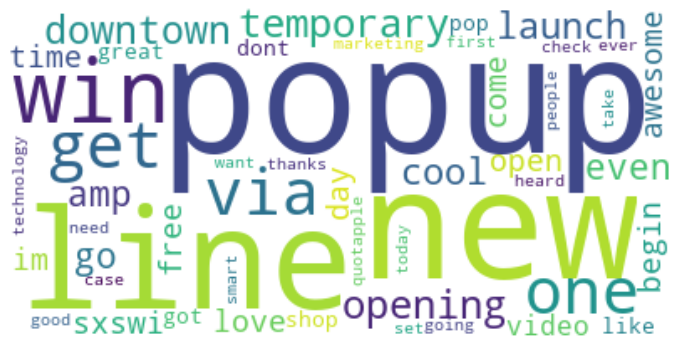

In [47]:
generate_word_cloud(positive_apple, additional_stopwords=apple_stopwords)

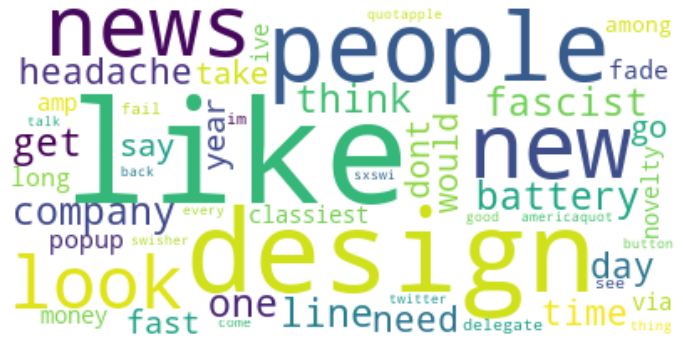

In [48]:
generate_word_cloud(negative_apple, additional_stopwords=apple_stopwords)

In [55]:
google_stopwords = ['google','called','android','app','apps','link','rt', 'quotgoogle','new','launch','circle','social','network','major','today']

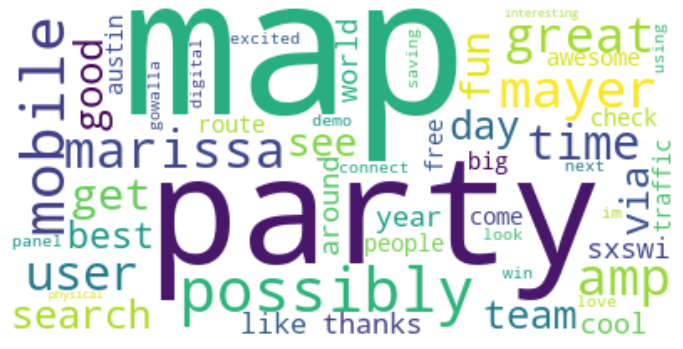

In [56]:
generate_word_cloud(positive_google, additional_stopwords=google_stopwords)

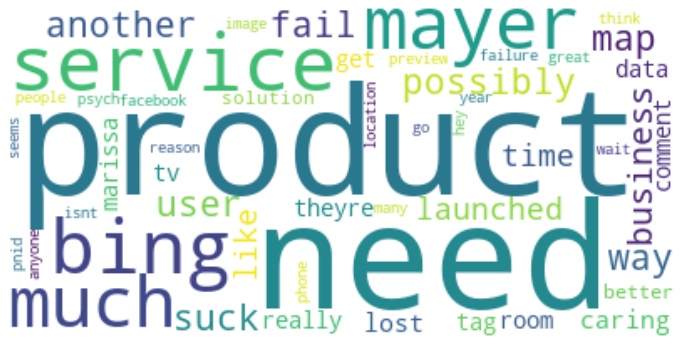

In [58]:
generate_word_cloud(negative_google, additional_stopwords= google_stopwords)

These word clouds say so much!! Both for either product, we see what really has people saying good or bad things about each. For Apple, it seems like the biggest success they had was with how the sxsw event went for them, as there was a lot of positive hype around the popup event. Conversely, the egative things people were saying seem to be issues with the design of the product or gripes with the company. For Google, whether positive or negative, the subject of conversation was about Google Circle, a social media platform app that I guess they were launching in the period of time that these tweets were collected. Essentially two sides existed, either calling Google's new product and exciting new way of connecting people, or a complete failure of a product.

 # Preparing for Modeling

In [59]:
#Converts emotion data into numbers to use for modeling
data['emotion'].replace({'Positive emotion': 2, 'Negative emotion': 0,\
                        'No emotion toward brand or product': 1},
                       inplace=True)

In [60]:
#Converts categorical product data into dummies to use in modeling
try:
    data = pd.get_dummies(data=data, columns = ['product'], drop_first=True)
except:
    data.head()
data.head()
X = data.drop(columns='emotion')
y = data['emotion']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)


## TF-IDF and TruncatedSVD

In [62]:
vectorizer = TfidfVectorizer()
tfidf_X_train = vectorizer.fit_transform(X_train['tweet'])
tfidf_X_test = vectorizer.transform(X_test['tweet'])

In [63]:
tfidf_X_train.shape

(6702, 8344)

In [64]:
tsvd = TruncatedSVD(5000)
tsvd.fit(tfidf_X_train)

TruncatedSVD(n_components=5000)

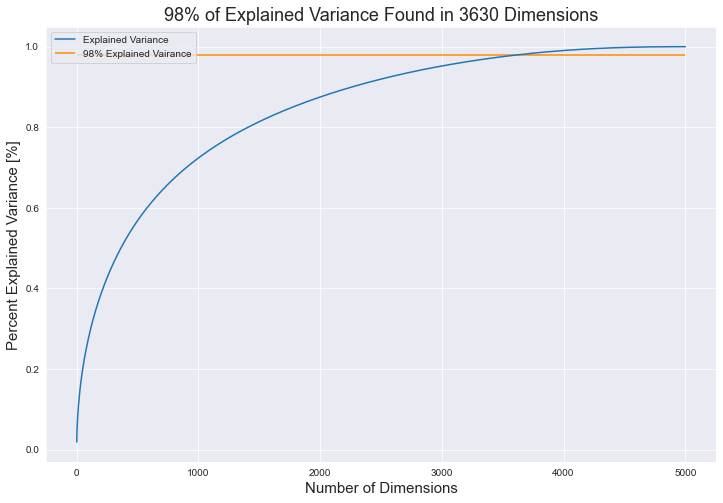

In [65]:
explained_variance = tsvd.explained_variance_ratio_.cumsum()
ideal_dimensions = 5000 - len(explained_variance[explained_variance >= 0.98]) +1

plt.figure(figsize=(12,8))

dimensions = np.arange(1, 5001)
plt.plot(dimensions, explained_variance, label= 'Explained Variance')
plt.hlines(y=0.98, xmin=0, xmax=5000,  colors='darkorange', label ="98% Explained Vairance")
plt.legend()

plt.title(f"98% of Explained Variance Found in {ideal_dimensions} Dimensions", fontsize=18)
plt.ylabel("Percent Explained Variance [%]", fontsize=15)
plt.xlabel("Number of Dimensions", fontsize=15)
plt.show()

98% of the explained variance is preserved in 3630 dimensions. I will reduce my dataset to that and consider that as the dimensions I will use in my train and test sets for modeling. This is a reduction of by more than half, which I believe is pretty good. Will need to add on my non-word columns for additional information.

In [68]:
tsvd = TruncatedSVD(ideal_dimensions)
svd_X_train = tsvd.fit_transform(tfidf_X_train)
svd_X_test = tsvd.transform(tfidf_X_test)

In [69]:
svd_X_train.shape

(6702, 3630)

In [70]:
#Adding the other features back onto the datasets
train_products = X_train.drop(columns='tweet').to_numpy()
test_products = X_test.drop(columns='tweet').to_numpy()

svd_train_data = np.concatenate((svd_X_train, train_products) , axis=1)
svd_test_data = np.concatenate((svd_X_test, test_products), axis=1)

In [71]:
#Saving Files if performed on colab vs on computer
if os.getcwd() == '/content':
  with open('/content/drive/My Drive/Colab Notebooks/Phase04Project/Data/SVD_train_data.txt', 'wb') as fp:
    pickle.dump(svd_train_data, fp)
  with open('/content/drive/My Drive/Colab Notebooks/Phase04Project/Data/SVD_test_data.txt', 'wb') as fp:
    pickle.dump(svd_test_data, fp)
    
else:
    with open('../Data/SVD_train_data.txt', 'wb') as fp:
        pickle.dump(svd_train_data, fp)
    with open('../Data/SVD_test_data.txt', 'wb') as fp:
        pickle.dump(svd_test_data, fp)
    

In [72]:
y_train.value_counts()

1    4032
2    2259
0    411 
Name: emotion, dtype: int64

In [73]:
#Saving the target data by pickling as well
if os.getcwd() == '/content':
  with open('/content/drive/My Drive/Colab Notebooks/Phase04Project/Data/target_train_data.txt', 'wb') as fp:
    pickle.dump(y_train, fp)
  with open('/content/drive/My Drive/Colab Notebooks/Phase04Project/Data/target_test_data.txt', 'wb') as fp:
    pickle.dump(y_test, fp)
    
else:
    with open('../Data/target_train_data.txt', 'wb') as fp:
        pickle.dump(y_train, fp)
    with open('../Data/target_test_data.txt', 'wb') as fp:
        pickle.dump(y_test, fp)

## TF-IDF and TruncatedSVD on Bigrams

In [74]:
bigram_vectorizer = TfidfVectorizer(ngram_range= (2,2))
bigram_X_train = bigram_vectorizer.fit_transform(X_train['tweet'])
bigram_X_test = bigram_vectorizer.transform(X_test['tweet'])

In [75]:
bigram_X_train.shape

(6702, 31602)

In [76]:
max_dimensions = 6000
tsvd = TruncatedSVD(max_dimensions)
tsvd.fit(bigram_X_train)

TruncatedSVD(n_components=6000)

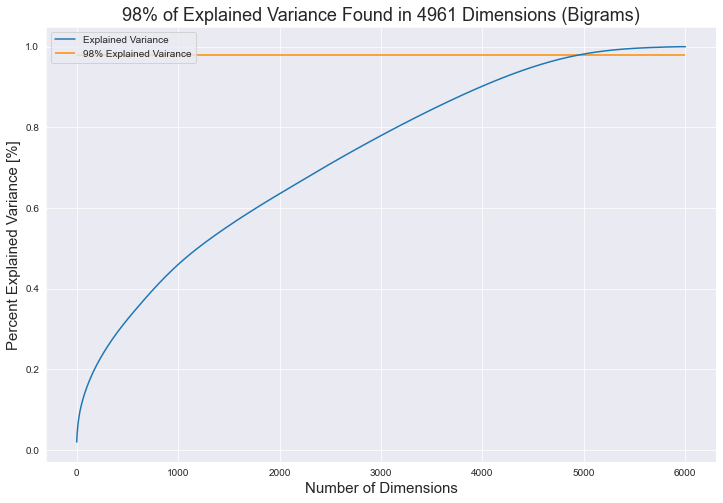

In [78]:
explained_variance = tsvd.explained_variance_ratio_.cumsum()
ideal_dimensions = max_dimensions - len(explained_variance[explained_variance >= 0.98]) +1

plt.figure(figsize=(12,8))

dimensions = np.arange(1, max_dimensions+1)
plt.plot(dimensions, explained_variance, label= 'Explained Variance')
plt.hlines(y=0.98, xmin=0, xmax=6000,  colors='darkorange', label ="98% Explained Vairance")
plt.legend()

plt.title(f"98% of Explained Variance Found in {ideal_dimensions} Dimensions (Bigrams)", fontsize=18)
plt.ylabel("Percent Explained Variance [%]", fontsize=15)
plt.xlabel("Number of Dimensions", fontsize=15)
plt.show()

98% percent of the explained variance can be found in 4961 dimensions. This is a drastic reduction of size in the bigram  data, which is more than 31,000 columns

In [79]:
tsvd = TruncatedSVD(ideal_dimensions)
svd_bigram_X_train = tsvd.fit_transform(bigram_X_train)
svd_bigram_X_test = tsvd.transform(bigram_X_test)

In [80]:
svd_bigram_train_data = np.concatenate((svd_bigram_X_train, train_products), axis=1)
svd_bigram_test_data = np.concatenate((svd_bigram_X_test, test_products), axis=1)

In [81]:
if os.getcwd() == '/content':
  with open('/content/drive/My Drive/Colab Notebooks/Phase04Project/Data/Bigram_train_data.txt', 'wb') as fp:
    pickle.dump(svd_bigram_train_data, fp)
  with open('/content/drive/My Drive/Colab Notebooks/Phase04Project/Data/Bigram_test_data.txt', 'wb') as fp:
    pickle.dump(svd_bigram_test_data, fp)
    
else:
    with open('../Data/Bigram_train_data.txt', 'wb') as fp:
        pickle.dump(svd_bigram_train_data, fp)
    with open('../Data/Bigram_test_data.txt', 'wb') as fp:
        pickle.dump(svd_bigram_test_data, fp)